# Siamese Neural Network

> An architecture for comparing pairs of inputs

In [ ]:
#| default_exp siamese

In [ ]:
#| hide
from nbdev.showdoc import *
from similarity_learning.utils import *

In [ ]:
#| hide
fix_notebook_widgets()

In [ ]:
#| export
from torch import nn
from torch.nn.functional import normalize

from fastai.vision.all import *


def normalized_squared_euclidean_distance(x1, x2):
    r"""
    Squared Euclidean distance over normalized vectors:
    $$\left\| \frac{x_1}{\|x_1\|}-\frac{x_2}{\|x_2\|} \right\|^2 $$
    """
    assert x1.dim() <= 2
    assert x2.dim() <= 2
    x1 = normalize(x1, dim=-1)
    x2 = normalize(x2, dim=-1)
    return (x1 - x2).pow(2).sum(dim=-1)


class ContrastiveLoss(BaseLoss):
    @delegates(nn.HingeEmbeddingLoss)
    def __init__(self, **kwargs):
        super().__init__(loss_cls=nn.HingeEmbeddingLoss, **kwargs)

    def __call__(self, input, target):
        return super().__call__(input, 2*target-1)  # hinge_embedding_loss expects targets to be 1 or -1


# @dataclass
class DistanceSiamese(Module):
    """Outputs the distance between two inputs in feature space"""
    def __init__(self, 
                 backbone: Module,  # embeds inputs in a feature space
                 distance_metric = normalized_squared_euclidean_distance):
        self.backbone = backbone
        self.distance_metric = distance_metric

    def forward(self, x):
        f1, f2 = L(x).map(self.backbone).map(nn.Flatten())
        return self.distance_metric(f1, f2)


In [ ]:
#| export
from matplotlib.ticker import PercentFormatter
from tqdm.autonotebook import tqdm
import numpy as np

@patch
def plot_distance_histogram(self: DistanceSiamese, pairs_dl: TfmdDL, label='Distance'):
    """Plots a histogram of intra-class and inter-class distances"""
    self.eval().cuda()
    
    with torch.no_grad():
        processed_batches = [(self(x), y) for x, y in tqdm(pairs_dl, desc='Computing distances')]
        distances, targets = [torch.cat(o).cpu().numpy() for o in zip(*processed_batches)]

    _hist(distances[targets==1], 'Intra-Class')
    _hist(distances[targets==0], 'Inter-Class')
    
    plt.legend()
    plt.xlabel(label)

def _hist(distances, label=None):
    weights = np.ones_like(distances) / len(distances)  # normalization for percentage ticks
    plt.hist(distances, label=label, alpha=.5, edgecolor='black', lw=1, weights=weights)
    plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

In [ ]:
from fastai_datasets.all import *

In [ ]:
classifier = resnet34(weights=ResNet34_Weights.DEFAULT)
siamese = DistanceSiamese(create_body(model=classifier, cut=-1))

In [ ]:
pairs = Pairs(Imagenette(160), .1)
dls = pairs.dls(after_item=Resize(128),
                after_batch=Normalize.from_stats(*imagenet_stats))

Class map: scanning targets: 0it [00:00, ?it/s]

Generating positive pairs:   0%|          | 0/473 [00:00<?, ?it/s]

Generating negative pairs:   0%|          | 0/473 [00:00<?, ?it/s]

Class map: scanning targets: 0it [00:00, ?it/s]

Generating positive pairs:   0%|          | 0/196 [00:00<?, ?it/s]

Generating negative pairs:   0%|          | 0/196 [00:00<?, ?it/s]

When starting with a decent backbone, positive pairs are closer than negative pairs:

Computing distances:   0%|          | 0/7 [00:00<?, ?it/s]

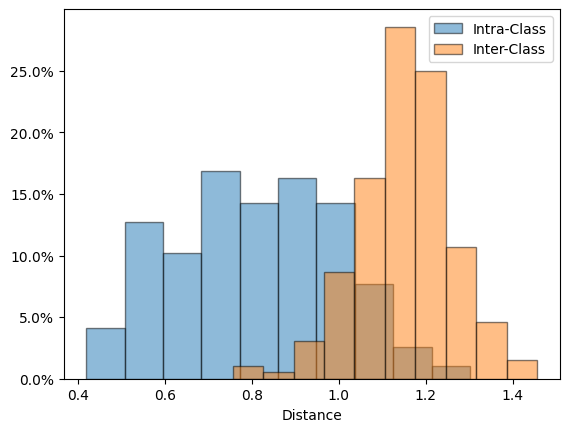

In [ ]:
siamese.plot_distance_histogram(dls.valid)

Train with contrastive loss:

In [ ]:
learn = Learner(dls, siamese, ContrastiveLoss(margin=1.5))
learn.fit_one_cycle(3)

epoch,train_loss,valid_loss,time
0,0.434352,0.290323,00:10
1,0.333588,0.345677,00:10
2,0.259585,0.240992,00:09


Computing distances:   0%|          | 0/7 [00:00<?, ?it/s]

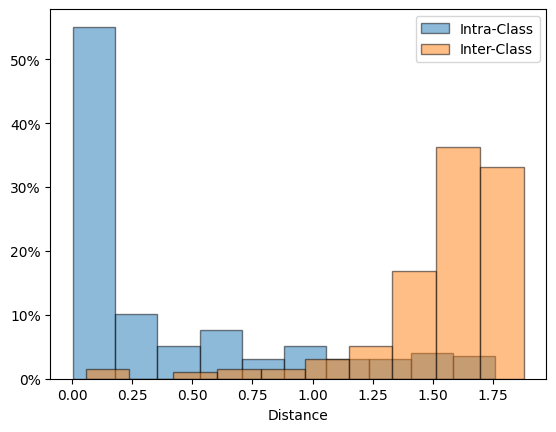

In [ ]:
siamese.plot_distance_histogram(dls.valid)

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()